# Do the SSN range residuals imply radar error?

The SSN range residuals must imply radar error of some kind unless a dynamically correct trajectory can be found that explains them otherwise.

A further least square fit is obtained below simultaneously to the inferred SSN range data of both SSNs and for Goldstone, to test for a closer fit with respect to all three.

In [1]:
from astropy import units as u
from astropy import constants as const
from astropy.time import Time

from poliastro.util import norm
from poliastro.frames import Planes
from poliastro.ephem import Ephem
from poliastro.bodies import Earth

from poliastro.twobody.orbit import Orbit
from poliastro.twobody.sampling import EpochsArray

from astropy.coordinates import solar_system_ephemeris

import numpy as np
import sys
sys.path.append('../')

from sim.stations import dss25, ssrAltair, ssrMillstone
from sim.tracking import Tracking
from sim.util import describe_orbit, describe_state, describe_trajectory

solar_system_ephemeris.set("de440")
goldstone_end = Tracking.NEAR_GOLDSTONE_END.value
ssn_start = Tracking.NEAR_SSN_START.value
ssn_end = Tracking.NEAR_SSN_END.value
sampling_interval = 60

In [2]:
ssn_offsets = np.arange(0, (ssn_end - ssn_start)/(1*u.s), sampling_interval)
ssn_epochs = ssn_start + (ssn_offsets << u.s)
print("Start and end epochs:", ssn_start, ssn_epochs[-1], "[", ssn_epochs.size, "]")

Start and end epochs: 1998-01-23 06:12:00.000 1998-01-23 06:53:00.000 [ 42 ]


In [3]:
near_ssn_start_rv = Ephem.from_horizons("NEAR", ssn_start, attractor=Earth, plane=Planes.EARTH_EQUATOR).rv(ssn_start)
describe_state(near_ssn_start_rv, dss25, ssn_start)

near_ssn_horizons_orbit = Orbit.from_vectors(Earth, near_ssn_start_rv[0], near_ssn_start_rv[1], ssn_start)
describe_orbit(near_ssn_horizons_orbit)


:AT: 1998-01-23 06:12:00.000
Geocentric distance: 38859.883216675225 km speed: 8.212204074470506 km / s
From Goldstone-25 : range  32925.106881197746 km , range rate  -7.678958819849895 km / s

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.9726496094731 deg
Eccentricity: 1.8133587958676256
Semilatus rectum: 19437.29186795066 km
Semimajor axix: -8494.317028570922 km
Periapse radius: 6908.927470076313 km , altitude: 530.7908700763128 km


In [4]:
near_ssn_ref_ephem = near_ssn_horizons_orbit.to_ephem(EpochsArray(ssn_epochs))
describe_trajectory(near_ssn_ref_ephem, dss25)


::TRAJECTORY::
Start and end ranges: 32464.30738350937 km 14333.210541419236 km
Start and end radial speeds: -7.678958819849894 km / s -6.93522887314112 km / s
Closest: 14333.210541419236 km speed 9.426865110527986 km / s  at  1998-01-23 06:53:00.000
Deflection: 3.302565499172899 deg


In [5]:
sim_meas = []
sim_altair_rv = []
sim_millstone_rv = []
sim_dss25_rv = []

for e in ssn_epochs:
    rv = near_ssn_ref_ephem.rv(e)

    sim_rv = ssrAltair.rv_with_rangelag(rv, e)
    sim_altair_rv.append(sim_rv)
    sim_altair_r, sim_altair_rr = ssrAltair.range_and_rate(sim_rv, e)

    sim_rv = ssrMillstone.rv_with_rangelag(rv, e)
    sim_millstone_rv.append(sim_rv)
    sim_millstone_r, sim_millstone_rr = ssrMillstone.range_and_rate(sim_rv, e)


    sim_rv = dss25.rv_with_rangelag(rv, e)
    sim_dss25_rv.append(sim_rv)
    sim_dss25_r, sim_dss25_rr = dss25.range_and_rate(sim_rv, e)

    sim_meas.append([sim_altair_r, sim_millstone_r, sim_dss25_r])

print(sim_meas)

[[<Quantity 35482.10823583 km>, <Quantity 35325.44019592 km>, <Quantity 32924.26352929 km>], [<Quantity 34992.67025567 km>, <Quantity 34871.30243306 km>, <Quantity 32463.47561342 km>], [<Quantity 34503.06081226 km>, <Quantity 34416.81559206 km>, <Quantity 32002.56940969 km>], [<Quantity 34013.28827363 km>, <Quantity 33961.97897874 km>, <Quantity 31541.55410871 km>], [<Quantity 33523.36197989 km>, <Quantity 33506.79230523 km>, <Quantity 31080.43998528 km>], [<Quantity 33033.29233821 km>, <Quantity 33051.25573733 km>, <Quantity 30619.23850417 km>], [<Quantity 32543.09092759 km>, <Quantity 32595.3699471 km>, <Quantity 30157.96243708 km>], [<Quantity 32052.77061475 km>, <Quantity 32139.13617115 km>, <Quantity 29696.6259919 km>], [<Quantity 31562.34568238 km>, <Quantity 31682.55627556 km>, <Quantity 29235.24495599 km>], [<Quantity 31071.83197126 km>, <Quantity 31225.63282792 km>, <Quantity 28773.83685488 km>], [<Quantity 30581.2470378 km>, <Quantity 30768.36917765 km>, <Quantity 28312.42112

In [6]:
from sim.fitorbit import OrbitFitter
fitter = OrbitFitter(near_ssn_horizons_orbit, [ssrAltair, ssrMillstone, dss25], max_iter=50, var=0.01, debug=True)

Range constraints:
a: -8409373.858285213 -8579260.198856631
ecc: 1.7952252079089492 1.831492383826302
inc: 1.8656334554096003 1.90332302016535
max iter: 50


In [7]:
from datetime import datetime 
start_time = datetime.now()
#print(start_time)

fitter.fit_rangerates_to_range_data(ssn_epochs, sim_meas)
time_elapsed = datetime.now() - start_time
print(fitter.report())
print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

describe_orbit(fitter.orbit)
describe_trajectory(fitter.ephem, dss25)

[[<Quantity -714609.61499209 km / d>, <Quantity -676237.18849992 km / d>, <Quantity -669289.84431292 km / d>], [<Quantity -352395.34571956 km / d>, <Quantity -326979.18925938 km / d>, <Quantity -331767.29942839 km / d>], [<Quantity -352518.79924988 km / d>, <Quantity -327230.52551811 km / d>, <Quantity -331852.46668619 km / d>], [<Quantity -352636.22781743 km / d>, <Quantity -327482.3615911 km / d>, <Quantity -331931.01670451 km / d>], [<Quantity -352746.93149017 km / d>, <Quantity -327734.40493025 km / d>, <Quantity -332002.16887117 km / d>], [<Quantity -352850.14200908 km / d>, <Quantity -327986.32888557 km / d>, <Quantity -332065.06639613 km / d>], [<Quantity -352945.01564826 km / d>, <Quantity -328237.76896926 km / d>, <Quantity -332118.76830995 km / d>], [<Quantity -353030.6252465 km / d>, <Quantity -328488.31867977 km / d>, <Quantity -332162.24052741 km / d>], [<Quantity -353105.95130202 km / d>, <Quantity -328737.52482812 km / d>, <Quantity -332194.34585402 km / d>], [<Quantity 

20. 31575.945702 {'a': -8558529.612532627, 'ecc': 1.7978138901697727, 'inc': 1.8815067140694643, 'nu': -1.7964682649897667, 'raan': 1.4664120329998194, 'argp': 3.4062952582395503}
21. 31575.948384 {'a': -8558529.612532627, 'ecc': 1.7978138901697727, 'inc': 1.8815067140694643, 'nu': -1.7964682883679548, 'raan': 1.466412055272848, 'argp': 3.4062952582395503}
22. 31575.948454 {'a': -8558529.612532627, 'ecc': 1.7978138901697727, 'inc': 1.8815067140694643, 'nu': -1.7964682883679548, 'raan': 1.4664120329998194, 'argp': 3.4062952621745657}
23. 29020.672542 {'a': -8573039.861268876, 'ecc': 1.8308506584847677, 'inc': 1.8687464717773354, 'nu': -1.7555155587496378, 'raan': 2.117163157774276, 'argp': 4.095499201446012}
24. 29020.672539 {'a': -8573039.851743067, 'ecc': 1.8308506584847677, 'inc': 1.8687464717773354, 'nu': -1.7555155587496378, 'raan': 2.117163157774276, 'argp': 4.095499201446012}
25. 29020.672535 {'a': -8573039.861268876, 'ecc': 1.8308506583538398, 'inc': 1.8687464717773354, 'nu': -1

In [8]:
print(fitter.result.residual)

[1039.695764691876, 564.8302065712159, 852.2903578226782, -3126.8425697940615, -3454.3924012167527, -3023.1013065768993, -3097.3991056038976, -3426.2725176443664, -2988.735310857493, -3065.5677820523374, -3395.8704249587017, -2952.017118656794, -3031.138094702838, -3362.991680105789, -2912.7749548309394, -2993.8792574043846, -3327.4236308938994, -2870.8239943543285, -2953.5382131503516, -3288.933670637879, -2825.9655186520235, -2909.837483430681, -3247.2673517935486, -2777.986074956022, -2862.4728577166634, -3202.146358717064, -2726.6566590501416, -2811.1109311375435, -3153.266344536593, -2671.7319484275076, -2755.3865074146984, -3100.2946439252137, -2612.9496212403346, -2694.899896440159, -3042.8678828745674, -2550.029806771039, -2629.2141525164957, -2980.5895191347136, -2482.6747259440126, -2557.8523213023595, -2913.0273636493866, -2410.5685960118108, -2480.294792476794, -2839.7111552498823, -2333.377892573129, -2395.9768924993778, -2760.1302891959654, -2250.752084872519, -2304.28689

In [9]:
altair_shifts = []
millstone_shifts = []
dss25_shifts = []

for i, e in enumerate(ssn_epochs[1:]):
    ref_rv = near_ssn_ref_ephem.rv(e)

    ref_r, ref_rr = ssrAltair.range_and_rate(sim_altair_rv[i], e)
    meas_r, meas_rr = ssrAltair.range_and_rate(fitter.ephem.rv(e), e)
    altair_shifts.append((meas_r - ref_r).to_value(u.m))

    ref_r, ref_rr = ssrMillstone.range_and_rate(sim_millstone_rv[i], e)
    meas_r, meas_rr = ssrMillstone.range_and_rate(fitter.ephem.rv(e), e)
    millstone_shifts.append((meas_r - ref_r).to_value(u.m))

    ref_r, ref_rr = dss25.range_and_rate(sim_dss25_rv[i], e)
    meas_r, meas_rr = dss25.range_and_rate(fitter.ephem.rv(e), e)
    dss25_shifts.append((meas_r - ref_r).to_value(u.m))

Though a complete null is not obtained, unlike the fit for Millstone alone, the residuals for both SSN and Goldstone ranges are reduced below 200 m. This is well within the uncertainty [previously estimated using Horizons LOS and AOS data](near_gapcheck.ipynb) due to Earth's precession, solar wind, etc.

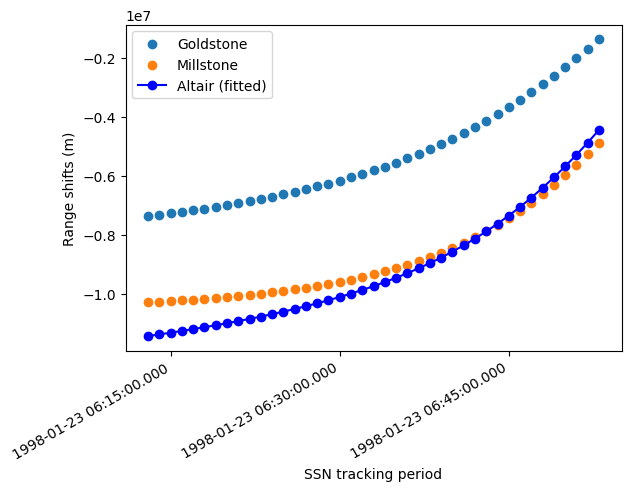

In [10]:
import matplotlib.pyplot as plt
from astropy import visualization
with visualization.time_support():
    plt.xlabel('SSN tracking period')
    plt.ylabel('Range shifts (m)')
    plt.scatter(ssn_epochs[1:], dss25_shifts, label="Goldstone")
    plt.scatter(ssn_epochs[1:], millstone_shifts, label="Millstone")
    plt.plot(ssn_epochs[1:], altair_shifts, 'bo-', label="Altair (fitted)")
    plt.legend(loc="best")
    plt.gcf().autofmt_xdate()

In [11]:
altair_doppler = []
millstone_doppler = []
dss25_doppler = []

for e in ssn_epochs[1:]:
    ref_rv = near_ssn_ref_ephem.rv(e)

    ref_r, ref_rr = ssrAltair.range_and_rate(ref_rv, e)
    meas_r, meas_rr = ssrAltair.range_and_rate(fitter.ephem.rv(e), e)
    altair_doppler.append((meas_rr - ref_rr).to_value(u.m/u.s))

    ref_r, ref_rr = ssrMillstone.range_and_rate(ref_rv, e)
    meas_r, meas_rr = ssrMillstone.range_and_rate(fitter.ephem.rv(e), e)
    millstone_doppler.append((meas_rr - ref_rr).to_value(u.m/u.s))

    ref_r, ref_rr = dss25.range_and_rate(ref_rv, e)
    meas_r, meas_rr = dss25.range_and_rate(fitter.ephem.rv(e), e)
    dss25_doppler.append((meas_rr - ref_rr).to_value(u.m/u.s))

The Doppler residuals are no worse than with the fits to Altair and Millstone separately, but still too large by two orders. A further test

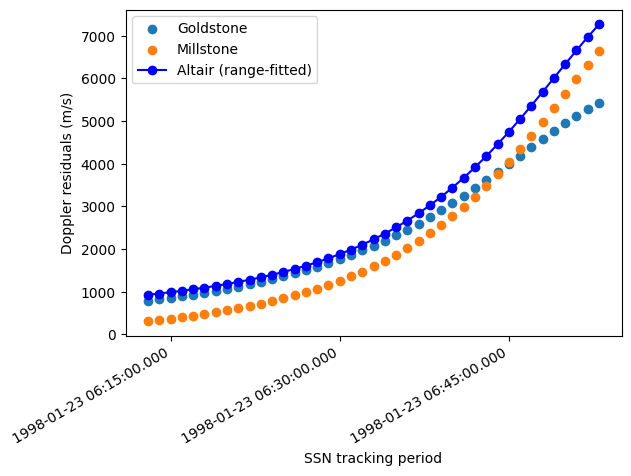

In [12]:
with visualization.time_support():
    plt.xlabel('SSN tracking period')
    plt.ylabel('Doppler residuals (m/s)')
    plt.scatter(ssn_epochs[1:], dss25_doppler, label="Goldstone")
    plt.scatter(ssn_epochs[1:], millstone_doppler, label="Millstone")
    plt.plot(ssn_epochs[1:], altair_doppler, 'bo-', label="Altair (range-fitted)")
    plt.legend(loc="best")
    plt.gcf().autofmt_xdate()